In [149]:
import torch
from pathlib import Path
import numpy as np
import os
from matsimAI.flowsim_dataset import FlowSimDataset
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
import itertools
import seaborn as sns
from tbparse import SummaryReader
sns.set_style("whitegrid")
sns.set_palette("muted")

In [95]:
results_path = Path("/home/isaacp/repos/MatsimAI/cluster_results/results/0428162326_nclusters_10_utahnetwork")
matsim_output = Path("/home/isaacp/repos/MatsimAI/outputs/output_10c")
scenario_path = Path("/home/isaacp/repos/MatsimAI/scenarios/cluster_scenarios/utah_10c")

last_iter = sorted([int(s.split(".")[1]) for s in os.listdir(matsim_output / "ITERS")])[-1]
last_iteration_path = Path(matsim_output, "ITERS", f"it.{last_iter}")

In [96]:
dataset = FlowSimDataset(results_path.parent, Path(scenario_path, "utahnetwork.xml"),  Path(scenario_path, "utahcounts.xml"), 10)
target_graph = dataset.target_graph
sensor_idxs = dataset.sensor_idxs

# Link Count Comparison

In [56]:
flows = torch.load(results_path / "best_flows.pt")
OD = flows["OD"].to("cpu")
link_flows = flows["LinkFlows"].to("cpu")
target_flows = target_graph.edge_attr

/tmp/ipykernel_456689/2012471147.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  flows = torch.load(results_path / "best_flows.pt")


In [102]:
target_flows.shape

torch.Size([3785, 24])

In [73]:
diff = torch.sum(torch.abs(target_flows[sensor_idxs, :] - link_flows[sensor_idxs, :]), dim=1) 
min_sensor_idx = sensor_idxs[torch.argmin(diff)] 
max_sensor_idx = sensor_idxs[torch.argmax(diff)] 
print(f"Min sensor idx: {min_sensor_idx}, Max sensor idx: {max_sensor_idx}")

Min sensor idx: 1711, Max sensor idx: 1291


In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_tensor_flows(predicted_flows, target_flows, link, title):
    # plot bar chart of predicted flows and target flows
    pred_link_flows = predicted_flows[link].detach().cpu().numpy()
    target_link_flows = target_flows[link].detach().cpu().numpy()

    hours = np.arange(predicted_flows.shape[1])  # Assuming 24 hours
    bar_width = 0.4

    plt.figure(figsize=(12, 6))
    plt.bar(
        hours,
        pred_link_flows,
        width=bar_width,
        color="blue",
        label="Predicted flows",
    )
    plt.bar(
        hours + bar_width,
        target_link_flows,
        width=bar_width,
        color="red",
        label="Target flows",
    )
    plt.xlabel("Hour")
    plt.ylabel("Flows")
    plt.title(f"{title} - Link {link}")
    plt.xticks(hours + bar_width / 2, np.arange(1, predicted_flows.shape[1] + 1))
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


def plot_link_flows(dataset, last_iteration_path, last_iter, link_idx, title):
    link = dataset.edge_mapping.inverse[link_idx]
    df = pd.read_csv(Path(last_iteration_path, f"{last_iter}.countscompare.txt"), sep="\t")

    df_link = df[df["Link Id"] == int(link)]

    unique_hours = pd.unique(df_link["Hour"])
    bar_width = 0.4  # Width of each bar

    # X positions for each set of bars
    hours = np.arange(len(unique_hours))

    plt.figure(figsize=(12, 6))
    plt.bar(
        hours,
        df_link["MATSIM volumes"],
        width=bar_width,
        color="blue",
        label="Optimized MATSIM volumes"
    )
    plt.bar(
        hours + bar_width,
        df_link["Count volumes"],
        width=bar_width,
        color="red",
        label="UTA Count volumes"
    )

    # Labels, title, and legend
    plt.xlabel("Hour")
    plt.ylabel("Volumes")
    plt.title(f"{title} - Link {link}")
    plt.xticks(hours + bar_width / 2, unique_hours)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


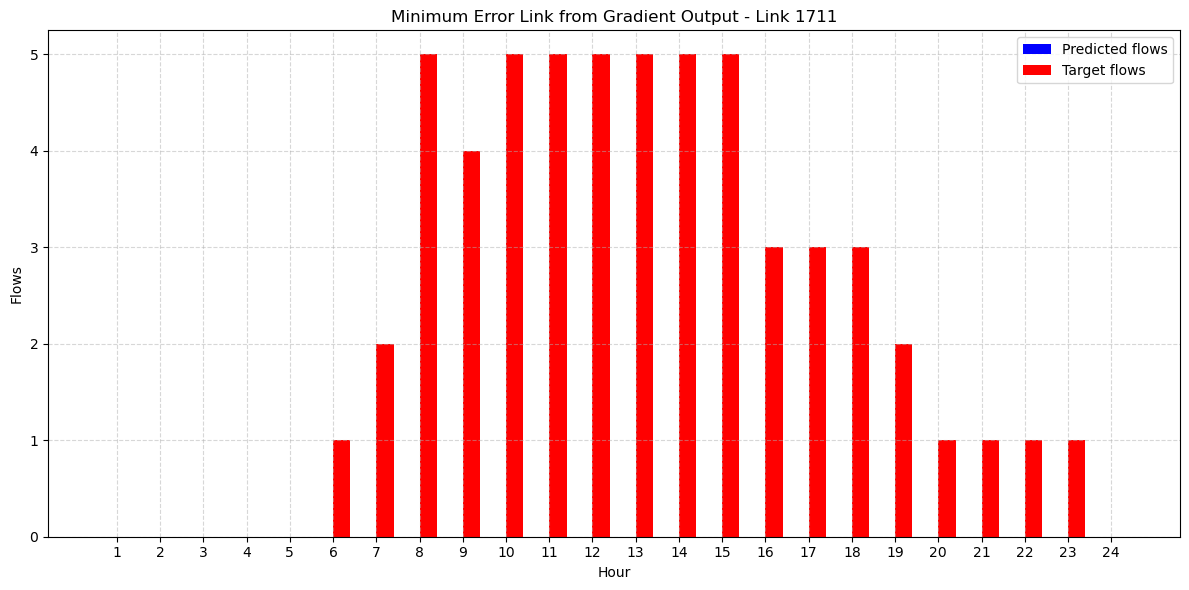

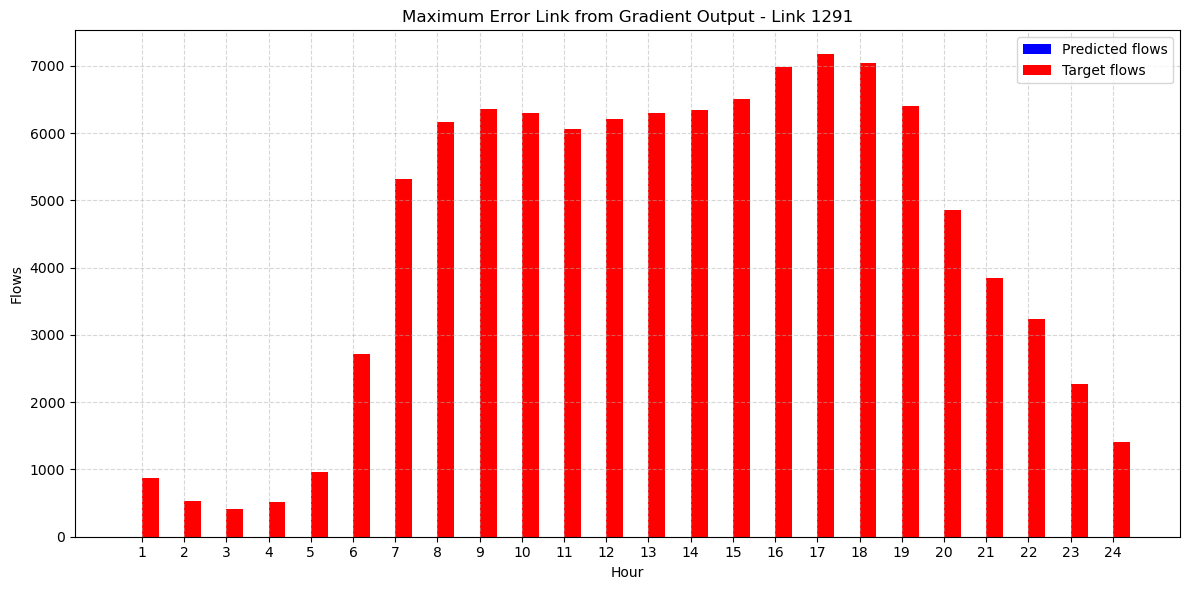

In [143]:
plot_tensor_flows(link_flows, target_flows, min_sensor_idx, "Minimum Error Link from Gradient Output")
plot_tensor_flows(link_flows, target_flows, max_sensor_idx, "Maximum Error Link from Gradient Output")

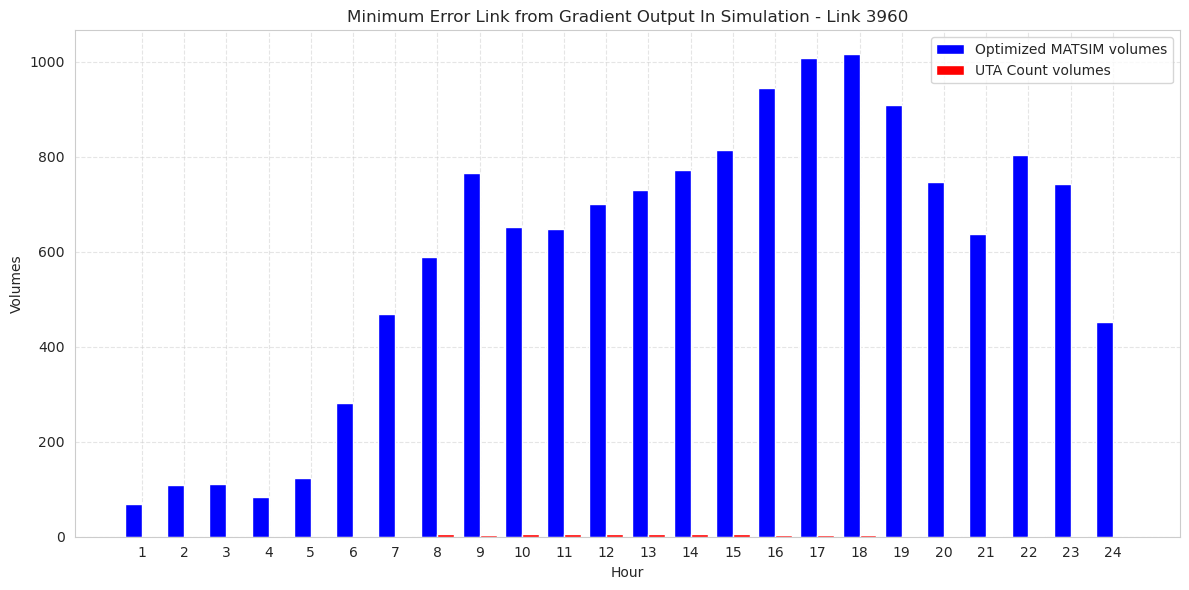

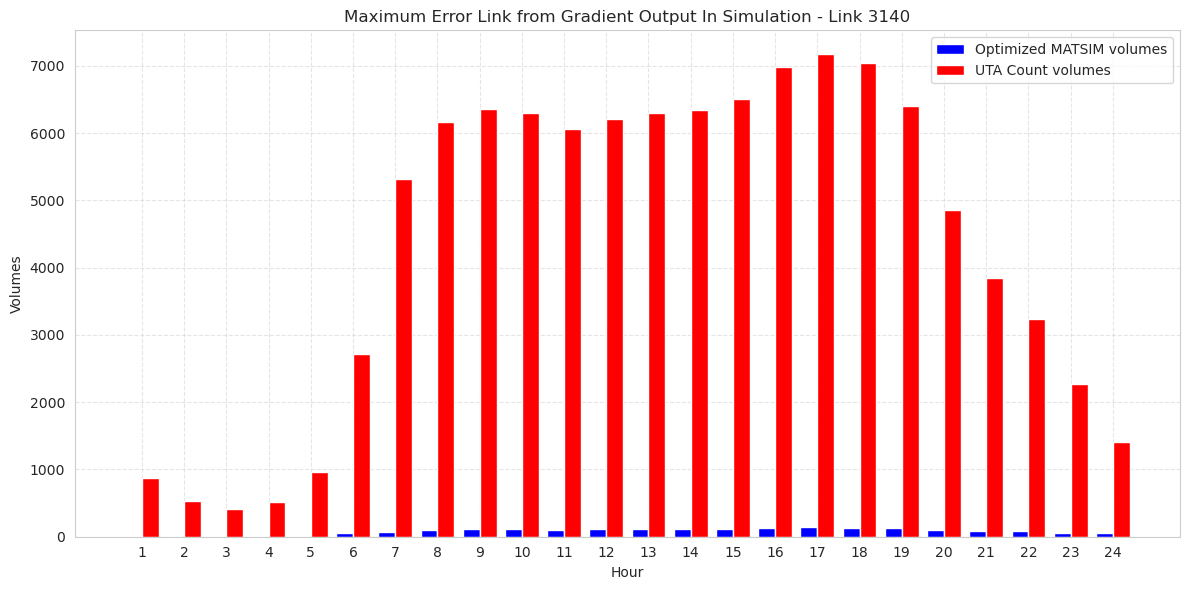

In [154]:
plot_link_flows(dataset, last_iteration_path, last_iter, min_sensor_idx, "Minimum Error Link from Gradient Output In Simulation")
plot_link_flows(dataset, last_iteration_path, last_iter, max_sensor_idx, "Maximum Error Link from Gradient Output In Simulation")

# Tensorboard Results

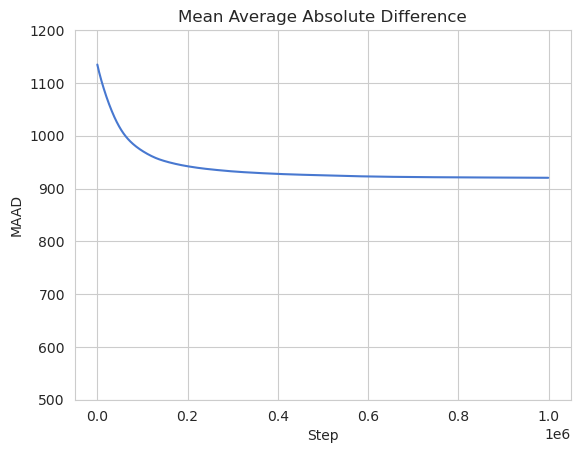

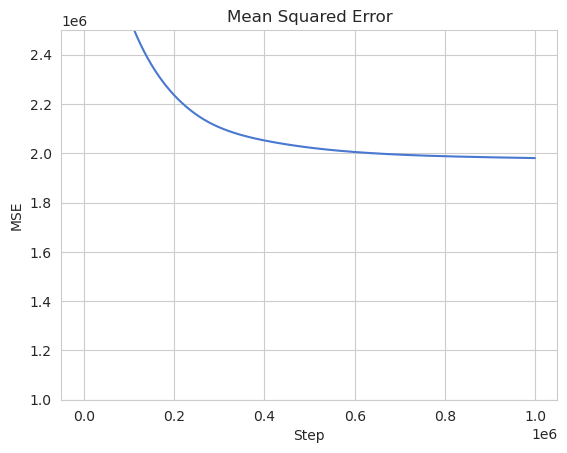

In [153]:
df = SummaryReader(Path(results_path, "logs")).scalars

mad_loss = df[df['tag'] == 'Logs/mad']
plt.plot(mad_loss['step'], mad_loss['value'])

plt.title("Mean Average Absolute Difference")
plt.xlabel("Step")
plt.ylabel("MAAD")
plt.ylim(500,1200)
plt.show()

mad_loss = df[df['tag'] == 'Loss/mse']
plt.plot(mad_loss['step'], mad_loss['value'])
    
plt.title("Mean Squared Error")
plt.xlabel("Step")
plt.ylabel("MSE")
plt.ylim(1e6, 2.5e6)
plt.show()

# Clusters

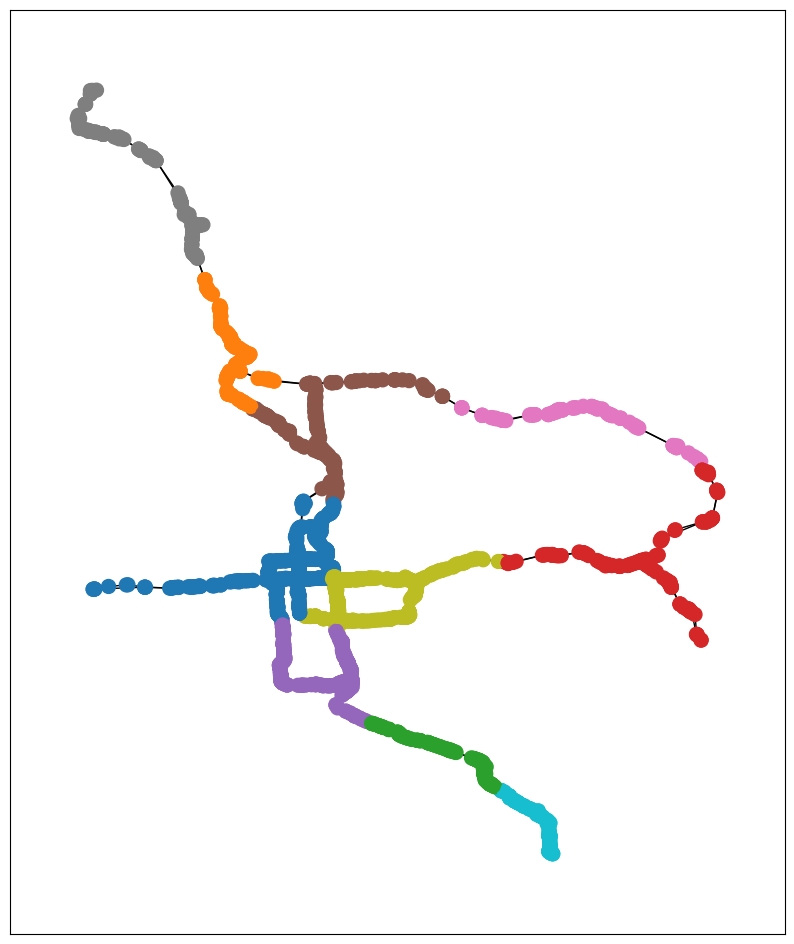

In [148]:
clusters = {}
cluster_path = Path(results_path, "clusters.txt")

with open(cluster_path, "r") as f:
    for line in f.readlines():
        key,vals = line.strip().split(":")
        vals = vals.split(",")[:-1]
        vals = [dataset.node_mapping[v] for v in vals]
        clusters[key] = vals


edge_idx = dataset.target_graph.edge_index.t().numpy()
pos = dataset.target_graph.pos.numpy()
nx_graph = nx.Graph()
nx_graph.add_edges_from(edge_idx)

colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
color_cycle = itertools.cycle(colors)

# Map node -> color
node_color_map = {}

for cluster_id, nodes in clusters.items():
    color = next(color_cycle)
    for node in nodes:
        node_color_map[node] = color

node_colors = [node_color_map.get(node, 'gray') for node in nx_graph.nodes()]

plt.figure(figsize=(10,12))
nx.draw_networkx(nx_graph, pos, with_labels=False, node_color=node_colors, node_size=100)